# Policy Gradient Methods

This notebook contains implementations of four policy gradient methods: a vanilla implementation of the REINFORCE algorithm, a variant of REINFORCE with a learned value function as baseline, one-step Actor-Critic and Actor-Critic with eligibility traces. The policy $\pi(a|s)$ is approximated using a quasi-linear function $\hat{\pi}(a|s,\boldsymbol{\theta})=softmax(s\boldsymbol{\theta})$ with $\boldsymbol{\theta} \in \mathbb{R}^{|S| \times |A|}$. Other, more powerful function approximators could also be used (e.g. neural network), but as can be seen below, for simple task the linear method suffices. It has been chosen since it illustrates better what is going on under the hood.

Arguably the most important computation in the algorithms is the gradient of the log-probability $\nabla \log \pi(A_t|S_t,\boldsymbol{\theta})$. In the case of the above function $\nabla \hat{\pi}(A_t|S_t,\boldsymbol{\theta})=\nabla softmax_{A_t}(S_t\boldsymbol{\theta})= softmax_{A_t}(s\boldsymbol{\theta}) S_t$, i.e. the gradient of the softmax probability of $A_t$ given $S_t$ is the softmax probability times $S_t$. Thus, the gradient reduces to $\nabla \log \pi(A_t|S_t,\boldsymbol{\theta})= \frac{\nabla \hat{\pi}(A_t|S_t,\boldsymbol{\theta})}{\hat{\pi}(A_t|S_t,\boldsymbol{\theta})}=\frac{softmax_{A_t}(S_t\boldsymbol{\theta}) S_t}{softmax_{A_t}(S_t\boldsymbol{\theta})}=S_t$. It is clear that the chosen quasi-linear function greatly reduces the computational load. Also, it enables to compute the gradient by hand instead of relying on autodiff packages.

The learned value function for the Actor-Critic methods is chosen likewise, i.e. $\hat{v}(s,\mathbf{w})=s\mathbf{w}$ with $\mathbf{w}\in\mathbb{R}^{|S|}$.

In order to compare the methods, they are all trained on one environment: the well-known cart pole task. However, the algorithms are implemented to use the `Env` abstraction provided by the `gym` package. In principle, each algorithm can be used with every task which implements the `Env` class (and represents the state and action spaces using `Box` or `Discrete`).

Actions are chosen randomly, but according to their probabilities. At each step $t$ action $A_t$ is sampled randomly from $A$, but each action $A_i \in A$ is assigned its softmax probability $softmax_{A_i}(S_t\boldsymbol{\theta})$ as weight. It would also be possible to greedily choose an action according to the softmax probabilities, only in this case ties have to be broken randomly in order for exploration to work.

An annoying problem arose when calculating softmax probabilities. Unfortunately, this requires computing $exp(s)$. This will result in overflow errors pretty soon, as even $exp(1000)$ is an excessively large number. There exist some ways to deal with that, but in this case simply care was taken not to let the values exceed large numbers.

An interesting observation for the cart pole task was that actually, the better the learned policy becomes, the longer the learning process takes. This is because the episodes will continue for a longer time if the agent chooses the optimal actions. This will also generalize to other episodic tasks of variable length.

In [1]:
from gym import make
from gym.spaces.box import Box
from gym.spaces.discrete import Discrete
import numpy as np
import matplotlib.pyplot as plt

In [2]:
seed = 123  # Fix env seed for reproducibility

In [3]:
env = make('CartPole-v0')
env.seed(seed)

[123]

In [4]:
def softmax(x):
    "Computes the softmax probabilities of vector x"
#     scale = max(x.max(), abs(x.min())) / 5  # enables softmax computation with large values, but might be counterproductive depending on the succeeding steps
    e = np.exp(x - np.max(x))
#     e = np.exp(x)
    return e / e.sum()

def policy(state, theta):
    "Returns a probability distribution over the Action space for a given state and learnable parameters theta"
    return softmax(np.dot(theta, state))

def value(state, w):
    "Returns the value of the given state using the learnable parameters w"
    return np.dot(state, w)

def one_hot_encode(n, i):
    "One hot encodes a value i out of n possible values"
    encoding = np.zeros(n)
    encoding[i] = 1
    return encoding

def convert_state(state, env):
    "Converts the state returned by `env.step()` to be useable by the algorithm"
    if type(env.observation_space) is Box:
        state = state.astype(float)
    elif type(env.observation_space) is Discrete:
        state = one_hot_encode(env.observation_space.n, state)
    return state

In [5]:
def reinforce(env, alpha_theta, alpha_w=0., episodes=200, gamma=.9):
    """
    Applies the REINFORCE algorithm to the given environment problem.
    
    Args:
    - `env`: An instance of `gym.Env` which represents the task.
    - `alpha_theta`: The step size for the learnable policy parameters.
    - `alpha_w`: The step size for the learnable value parameters. If it is empty, REINFORCE without baseline is used.
    - `episodes`: The amount of episodes to run the algorithm.
    - `gamma`: The reward discounting factor.
    
    Returns:
    - the policy parameters
    - the steps needed per episode
    - the return per episode
    """
    assert(type(env.action_space) is Discrete)
    assert(type(env.observation_space) is Box or type(env.observation_space) is Discrete)
    baseline = alpha_w > 0
    if type(env.observation_space) is Box:
        theta = np.zeros((env.action_space.n, env.observation_space.shape[-1]))
        w = np.zeros(env.observation_space.shape[-1])
    elif type(env.observation_space) is Discrete:
        theta = np.zeros((env.action_space.n, env.observation_space.n))
        w = np.zeros(env.observation_space.n)
    episode = 0
    steps_per_episode = []
    return_per_episode = []
    while episode < episodes:
        episode += 1
        state = convert_state(env.reset(), env)  # state arrays might not be floats, but float is needed for calculations
        states = [state]
        rewards = []
        action_probs = []
        actions = []
        done = False
        while not done:
            probs = policy(state, theta)
            # Either sample randomly with probs as weights or greedily with breaking ties randomly
            action = np.random.choice(range(env.action_space.n), p=probs)
#             action = np.random.choice(np.flatnonzero(probs == probs.max()))
            state_new, reward, done, _ = env.step(action)
            state_new = convert_state(state_new, env)
            state = state_new
            actions.append(action)
            action_probs.append(probs[action])
            states.append(state_new)
            rewards.append(reward)
        for step in range(len(actions)):
            gammas = np.cumprod(np.full(len(actions) - step, gamma))
            return_ = rewards[step:] @ gammas
            if baseline:
                target = return_ - value(states[step], w)
                w += alpha_w * target * states[step]
            else:
                target = return_
            theta[actions[step]] += alpha_theta * gamma ** step * target * states[step]
        steps_per_episode.append(len(actions))
        return_per_episode.append(sum(rewards))
    return theta, steps_per_episode, return_per_episode
            

In [6]:
def actor_critic(env, alpha_theta, alpha_w, lambda_theta=.5, lambda_w=.5, episodes=200, gamma=.9, eligibility=True):
    """
    Applies the Actor-Critic algorithm to the given environment problem.
    
    Args:
    - `env`: An instance of `gym.Env` which represents the task.
    - `alpha_theta`: The step size for the learnable policy parameters.
    - `alpha_w`: The step size for the learnable value parameters.
    - `lambda_theta`: The hyperparameter for the eligibility trace of `theta`. Ignored if `eligibility=False`.
    - `lambda_w`: The hyperparameter for the eligibility trace of `w`. Ignored if `eligibility=False`.
    - `episodes`: The amount of episodes to run the algorithm.
    - `gamma`: The reward discounting factor.
    - `eligibility`: Whether to use the Actor-Critic variant with eligibility traces.
    
    Returns:
    - the policy parameters
    - the steps needed per episode
    - the return per episode
    """
    assert(type(env.action_space) is Discrete)
    assert(type(env.observation_space) is Box or type(env.observation_space) is Discrete)
    if type(env.observation_space) is Box:
        theta = np.zeros((env.action_space.n, env.observation_space.shape[-1]))
        w = np.zeros(env.observation_space.shape[-1])
        if eligibility:
            z_theta = np.zeros((env.action_space.n, env.observation_space.shape[-1]))
            z_w = np.zeros(env.observation_space.shape[-1])
    elif type(env.observation_space) is Discrete:
        theta = np.zeros((env.action_space.n, env.observation_space.n))
        w = np.zeros(env.observation_space.n)
        if eligibility:
            z_theta = np.zeros((env.action_space.n, env.observation_space.n))
            z_w = np.zeros(env.observation_space.n)
    episode = 0
    steps_per_episode = []
    return_per_episode = []
    while episode < episodes:
        episode += 1
        state = convert_state(env.reset(), env)
        rewards = []
        I = 1
        done = False
        while not done:
            probs = policy(state, theta)
            action = np.random.choice(range(env.action_space.n), p=probs)
#             action = np.random.choice(np.flatnonzero(probs == probs.max()))
            state_new, reward, done, _ = env.step(action)
            state_new = convert_state(state_new, env)
            next_value = 0 if done else value(state_new, w)
            target = reward + gamma * next_value - value(state, w)
            if eligibility:
                z_w = gamma * lambda_w * z_w + state
                z_theta[action] = gamma * lambda_theta * z_theta[action] + I * state
                w += alpha_w * target * z_w
                theta[action] += alpha_theta * target * z_theta[action]
            else:
                w += alpha_w * target * state
                theta[action] += alpha_theta * I * target * state
            I *= gamma
            state = state_new
            rewards.append(reward)
        steps_per_episode.append(len(rewards))
        return_per_episode.append(sum(rewards))
    return theta, steps_per_episode, return_per_episode
            

In [7]:
def run_experiment(env, algorithm, alpha_theta, alpha_w=0, gamma=.9, episodes=200, runs=100):
    "Runs the given algorithm multiple times and returns the resulting return and steps needed to per episode."
    steps_per_run = np.empty((runs,episodes))
    returns_per_run = np.empty((runs,episodes))
    for run in range(runs):
        theta, steps_per_episode, return_per_episode = algorithm(env, alpha_theta, alpha_w, gamma=gamma, episodes=episodes)
        steps_per_run[run] = steps_per_episode
        returns_per_run[run] = return_per_episode
    return steps_per_run, returns_per_run

In [8]:
%%time
steps_vanilla, returns_vanilla = run_experiment(env, reinforce, .01)

CPU times: user 1min 46s, sys: 57.8 ms, total: 1min 46s
Wall time: 1min 46s


In [16]:
%%time
steps_baseline, returns_baseline = run_experiment(env, reinforce, .01, .1)

CPU times: user 2min 2s, sys: 72.1 ms, total: 2min 2s
Wall time: 2min 2s


In [13]:
%%time
steps_ac, returns_ac = run_experiment(env, actor_critic, .1, .01)

CPU times: user 1min 8s, sys: 174 ms, total: 1min 8s
Wall time: 1min 8s


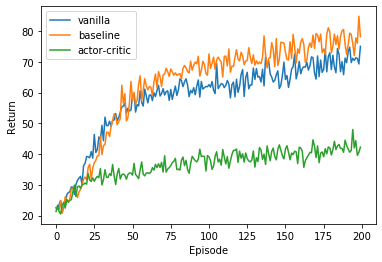

In [17]:
plt.plot(returns_vanilla.mean(axis=0), label="vanilla")
plt.plot(returns_baseline.mean(axis=0), label="baseline")
plt.plot(returns_ac.mean(axis=0), label="actor-critic")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Return")
plt.show()

The above plot shows the return for each episode averaged over 100 runs. Note that the (undiscounted) return of the CartPole task is simply the time steps spent in the episode. Episodes terminate after 200 steps, so 200 is the maximum return possible. It can be seen that no algorithm converges fully after 200 learning episodes, but all display significant improvement. The learning process was capped to 200 episodes since this already takes very long. The learning rate is also probably not optimal (probably too high), but lower learning rates simply took to long to converge.

It is easy to see the difference between the offline REINFORCE algorithms and the online Actor-Critic algorithm. The former improves performance significantly in the initial episodes but then slowly linearly improves. One the other hand, the performance of the Actor-Critic algorithm grows nearly linear with the number of episodes from the start. One can assume that Actor-Critic will reach REINFORCE performance after more episodes. However, it must also be said that the Actor-Critic algorithm is computationally faster and requires less memory.

In order to show the exploitive performance of the algorithms, their policy is tested and compared to the random agent below:

In [8]:
def test_policy(env, theta=None, episodes=100):
    "Tests a learned policy by applying it to the given `env`. If `theta` is not given, a random policy is chosen."
    steps_per_episode = []
    returns = []
    for episode in range(episodes):
        state = convert_state(env.reset(), env)
        env.render()
        step = 0
        rewards = []
        done = False
        while not done:
            step += 1
            if theta is None:
                action = np.random.choice(env.action_space.n)
            else:
                probs = policy(state, theta)
                action = np.random.choice(np.flatnonzero(probs == probs.max()))
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            env.render()
            state = convert_state(state, env)
        steps_per_episode.append(step)
        returns.append(sum(rewards))
    env.close()
    return returns, steps_per_episode

In [9]:
returns, steps_per_episode = test_policy(env)
print(f"Random agent avg return: {np.mean(returns)}, avg steps per episode: {np.mean(steps_per_episode)}")

Random agent avg return: 21.67, avg steps per episode: 21.67


In [12]:
theta, _, _ = reinforce(env, .01, episodes=200)
returns, steps_per_episode = test_policy(env, theta)
print(f"Vanilla REINFORCE avg return: {np.mean(returns)}, avg steps per episode: {np.mean(steps_per_episode)}")

Vanilla REINFORCE avg return: 91.75, avg steps per episode: 91.75


In [14]:
theta, _, _ = reinforce(env, .01, .1)
returns, steps_per_episode = test_policy(env, theta)
print(f"REINFORCE with baseline avg return: {np.mean(returns)}, avg steps per episode: {np.mean(steps_per_episode)}")

REINFORCE with baseline avg return: 90.24, avg steps per episode: 90.24


In [15]:
theta, _, _ = actor_critic(env, .1, .1, episodes=200)
returns, steps_per_episode = test_policy(env, theta)
print(f"Actor-Critic avg return: {np.mean(returns)}, avg steps per episode: {np.mean(steps_per_episode)}")

Actor-Critic avg return: 86.16, avg steps per episode: 86.16


It can be seen that the algorithms display better performance than the random agent, but still fail the task after ~ 90 steps. This is likely since the amount of learning episodes was not high enough for the rather simply function approximation used in this implementation.